In [1]:
# Import 
import os
import time
import json
import datetime
import sys

import pandas as pd
import numpy as np
from matplotlib import rcParams

from pathlib import Path
from tyssue import Sheet
from tyssue.io import hdf5

from tyssue.dynamics.sheet_gradients import height_grad
from tyssue.geometry import sheet_geometry
from tyssue.dynamics import units, effectors, model_factory
from tyssue.solvers.quasistatic import QSSolver
from tyssue.draw import sheet_view
import matplotlib.pyplot as plt
%matplotlib inline
rcParams['figure.dpi'] = 200

sys.path.append("..")
from peripodial.polarity import model
from peripodial.dynamics import EllipsoidLameGeometry as geom
from peripodial.anisotropy import anysotropy as aniso
from peripodial.anisotropy import face_orientation
from peripodial.polarity import update_weights
from peripodial.draw import draw_half_N_sheet

vispy  won't work


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
SIM_DIR = Path('/home/lglepin/Simulations/')
today = datetime.date.today()

sim_save_dir = SIM_DIR/f'{today.isoformat()}_YolkElasticity'

try:
    sim_save_dir.mkdir(parents=True, exist_ok=True)
except FileExistsError:
    pass

dsets = hdf5.load_datasets('../json_hdf5/lumen_elasticity.hdf5',
                               data_names=['vert', 'edge', 'face'])

with open('../json_hdf5/lumen_elasticity.json', 'r+') as fp:
    specs = json.load(fp)

sheet = Sheet('spherical', dsets)

sheet.update_specs(specs)
geom.update_all(sheet)


In [4]:
specs = {'face': {'prefered_perimeter': 3.8},
 'settings': {'geometry': 'spherical',
  'height_axis': 'z',
  'lumen_prefered_vol': 5700,
  'lumen_vol_elasticity': 0.01,
  'threshold_length': 0.01,
  'rosette_kwargs': {'threshold_length': 0.01, 'p_4': 0.01, 'p_5': 0.001},
  'barrier_radius': 13},
 'vert': {'barrier_elasticity': 280, 'delta_rho': 0},
        }

In [5]:
sheet.update_specs(specs, reset=True)
specs

{'face': {'prefered_perimeter': 3.8},
 'settings': {'geometry': 'spherical',
  'height_axis': 'z',
  'lumen_prefered_vol': 5700,
  'lumen_vol_elasticity': 0.01,
  'threshold_length': 0.01,
  'rosette_kwargs': {'threshold_length': 0.01, 'p_4': 0.01, 'p_5': 0.001},
  'barrier_radius': 13},
 'vert': {'barrier_elasticity': 280, 'delta_rho': 0}}

In [6]:
sheet.vert_df["delta_rho"] = sheet.settings["barrier_radius"]-sheet.vert_df["rho"]

In [7]:
sheet.vert_df

,x,y,z,is_active,rho,height,basal_shift,srce_o,radial_tension,unique_id,barrier_elasticity,viscosity,delta_rho
vert,,,,,,,,,,,,,
0,-1.337229,8.400666,-2.638139,1,8.906130,8.906130,4.0,0.000,0.0,0,280,0.1,4.093870
1,0.796772,8.489584,-1.026291,1,8.588432,8.588432,4.0,1.000,0.0,1,280,0.1,4.411568
2,-1.977101,8.267858,-1.059419,1,8.566725,8.566725,4.0,2.000,0.0,2,280,0.1,4.433275
3,-1.116566,8.438794,-1.598712,1,8.661168,8.661168,4.0,3.000,0.0,3,280,0.1,4.338832
4,-2.762881,8.082647,-2.748473,1,8.973115,8.973115,4.0,4.000,0.0,4,280,0.1,4.026885
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3295,5.435413,5.690134,8.288321,1,11.428806,11.428806,4.0,344.875,0.0,3295,280,0.1,1.571194
3296,4.717288,-6.378133,8.799046,1,11.847219,11.847219,4.0,442.500,0.0,3296,280,0.1,1.152781
3297,4.990228,-5.970929,9.594255,1,12.353303,12.353303,4.0,553.000,0.0,3297,280,0.1,0.646697


In [8]:
lumen_vol_egg= []
theta = np.pi / 3
bes = np.linspace(0, 1, 10)
sheets_obj = {}
solver = QSSolver(with_t1=True, with_t3=False)
diameters = []
middle_dia_s = [] 
aniso_cell_values_d = []
cell_perimeters = []
radius=[]
areas=[]

for i, be in enumerate(bes):
    sheet_copy= sheet.copy()
    theta = np.pi / 3
    z_orientation = update_weights(
        sheet_copy, 
        threshold_angle=theta, 
        below_threshold=0.5,
        above_threshold=1,
    )
    sheet_copy.vert_df['barrier_elasticity'] = be
    print(f"{i+1} / {10}", end=" ")
    res = solver.find_energy_min(sheet_copy, geom, model, options={"gtol": 1e-8})
    lumen_vol_egg.append(sheet_copy.settings['lumen_vol'])
    diameter = 2*(sheet_copy.vert_df["z"].max())
    sheets_obj[be] = sheet_copy
    diameters.append(diameter)
    center_verts =  sheet_copy.vert_df.loc[np.abs(sheet.vert_df["z"]) < 1]
    middle_dia = 2*(center_verts["x"]**2 + center_verts["y"]**2)**(0.5)
    middle_dia_s.append(middle_dia)
    sheet_copy.face_df['anisotropy'] = aniso(sheet_copy, coords = ['x','y','z'])
    center = np.abs(sheet_copy.face_df["z"]) < sheet_copy.face_df["z"].max()*0.75
    area = sheet_copy.face_df.loc[center, 'area'].mean()#area of the cell
    areas.append(area)
    aniso_cell = sheet_copy.face_df.loc[center, 'anisotropy']
    aniso_cell_values_d.append(aniso_cell)
    radius.append(sheet_copy.settings['barrier_radius'])
    print(sheet_copy.settings['barrier_radius'])
    cell_perimeter = sheet_copy.face_df.loc[center,'perimeter'].mean()
    cell_perimeters.append(cell_perimeter)

lumen_vol_egg = np.array(diameters)
print(diameters)


1 / 10 

/home/lglepin/miniforge3/envs/tyssue/lib/python3.10/site-packages/tyssue/topology/base_topology.py:196: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_vert_data[sheet.coords] = sheet.vert_df.loc[verts, sheet.coords].mean()


13
2 / 10 13
3 / 10 13
4 / 10 13
5 / 10 13
6 / 10 13
7 / 10 13
8 / 10 13
9 / 10 13
10 / 10 13
[34.453693118435076, 33.83426318500949, 32.87982121820114, 31.9615153898774, 32.4305177805957, 37.291019448741096, 30.073260444164895, 31.92215561016284, 30.51510519109161, 30.269968843340358]


In [9]:
bes = np.linspace(0, 1, 10)

In [10]:
br = bes.tolist()

In [11]:
br

[0.0,
 0.1111111111111111,
 0.2222222222222222,
 0.3333333333333333,
 0.4444444444444444,
 0.5555555555555556,
 0.6666666666666666,
 0.7777777777777777,
 0.8888888888888888,
 1.0]

<function matplotlib.pyplot.show(close=None, block=None)>

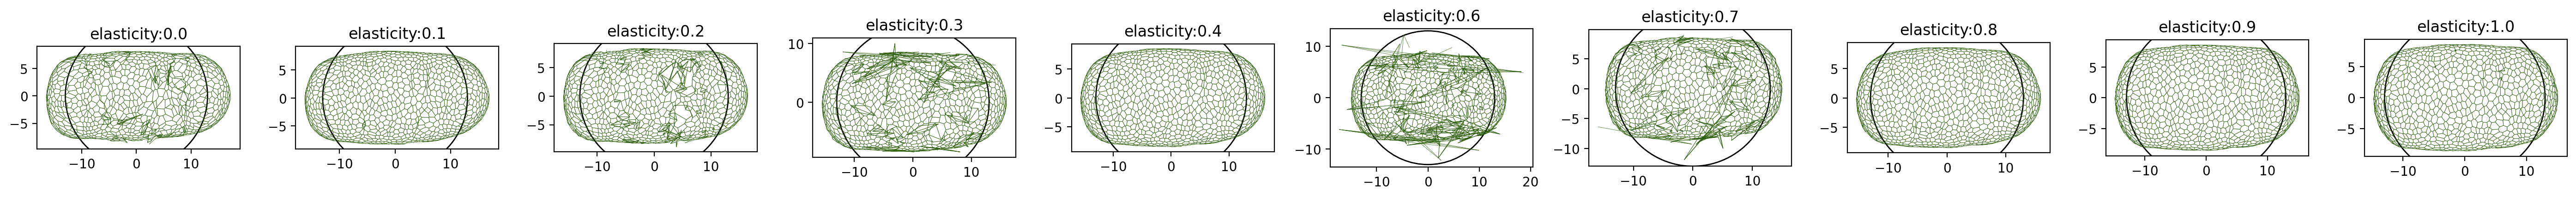

In [17]:
fig, axes = plt.subplots(1, len(sheets_obj), figsize=(28,8))

for i, (bes, sheet_copy) in enumerate(sheets_obj.items()):
    #plt.savefig(f'sheet {i+1}.png', transparent=True)
    fig, ax = draw_half_N_sheet(sheet_copy, axes[i], coords = ["z", "x"])
    circle = plt.Circle((0, 0), radius[i], edgecolor='black', facecolor='none')
    ax.add_artist(circle)
    ax.set_title('elasticity:{:.1f}'.format(br[i]))
    ax.set_facecolor('#ffffff')
    plt.tight_layout()
plt.savefig('../image/barrier_elasticity_pol.png', transparent=True)
plt.show


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


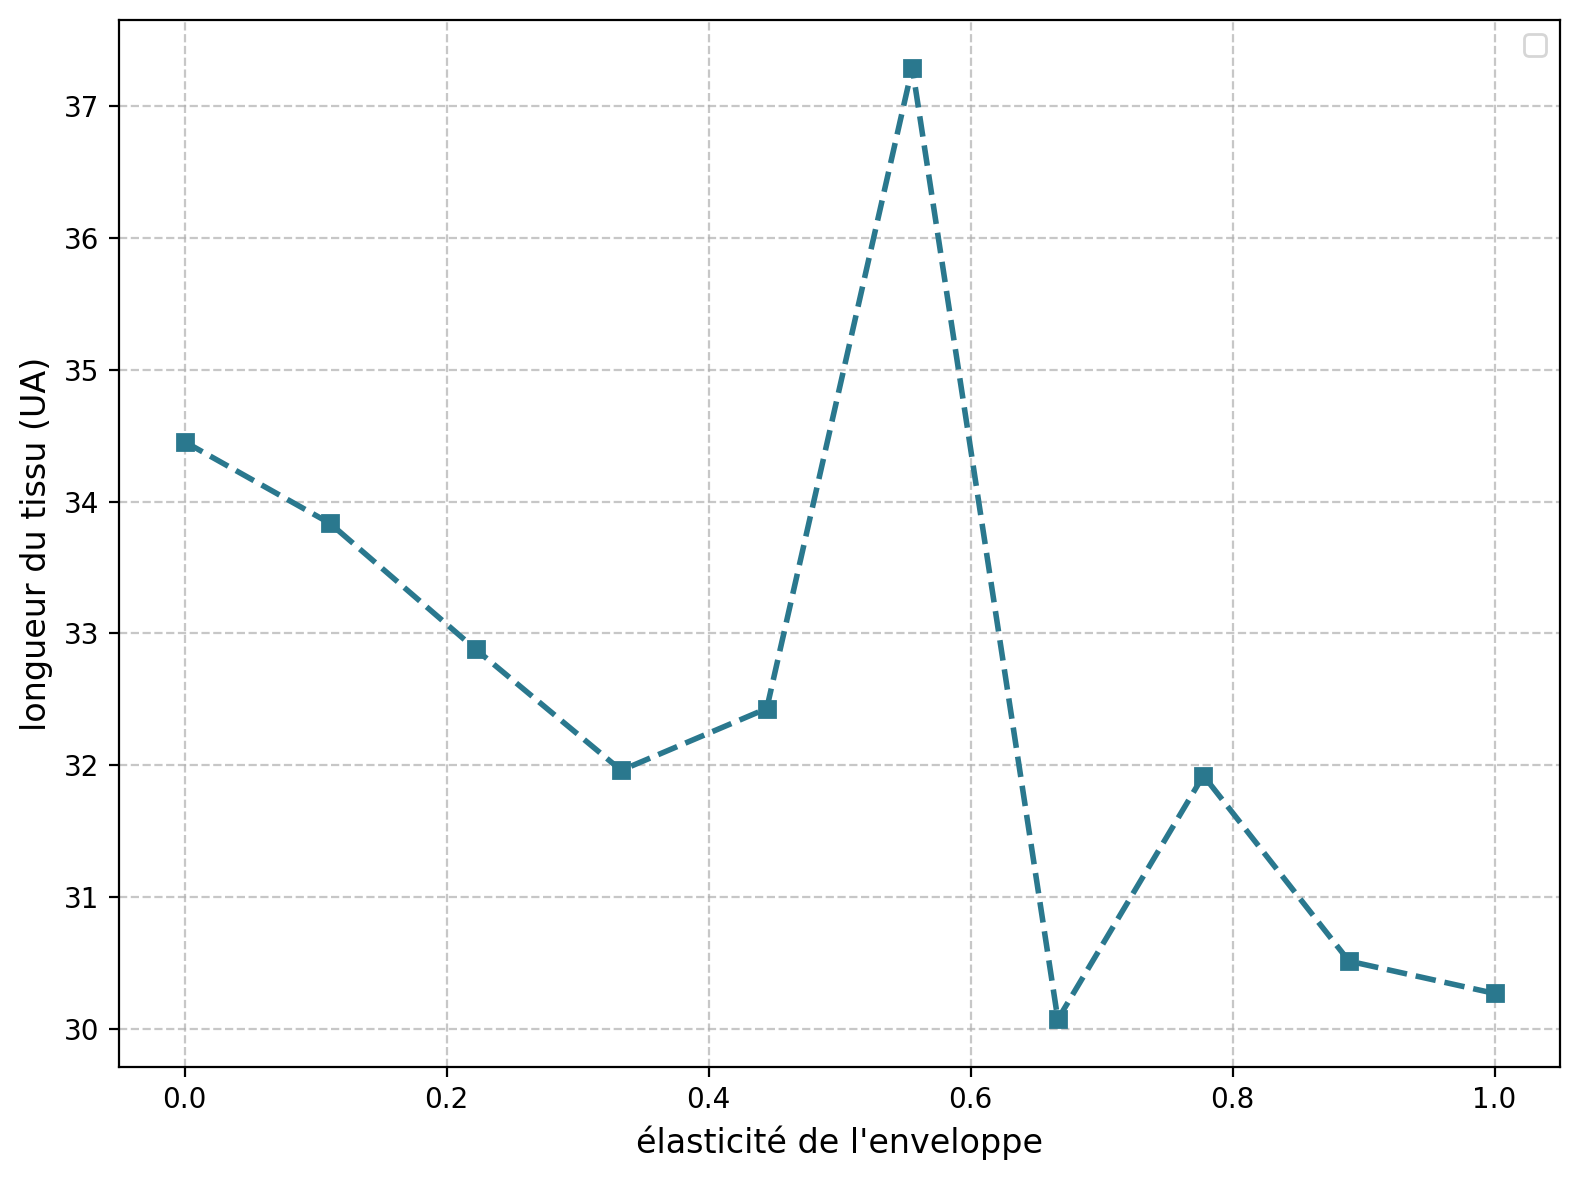

In [18]:
colors = plt.cm.viridis_r([0.2, 0.6])
fig, axs = plt.subplots(1, figsize=(8, 6))
axs.plot(br, diameters, color=colors[1], marker='s', linestyle='--', linewidth=2)
#axs.set_xscale('log')
axs.set_xlabel("élasticité de l'enveloppe", fontsize=12)
axs.set_ylabel('longueur du tissu (UA)', fontsize=12)
axs.grid(True, linestyle='--', alpha=0.7)
axs.legend(loc='best', fontsize=10)
plt.tight_layout()
plt.savefig('../image/tissue_length_barrier_elasticity_pol.png', transparent=True)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

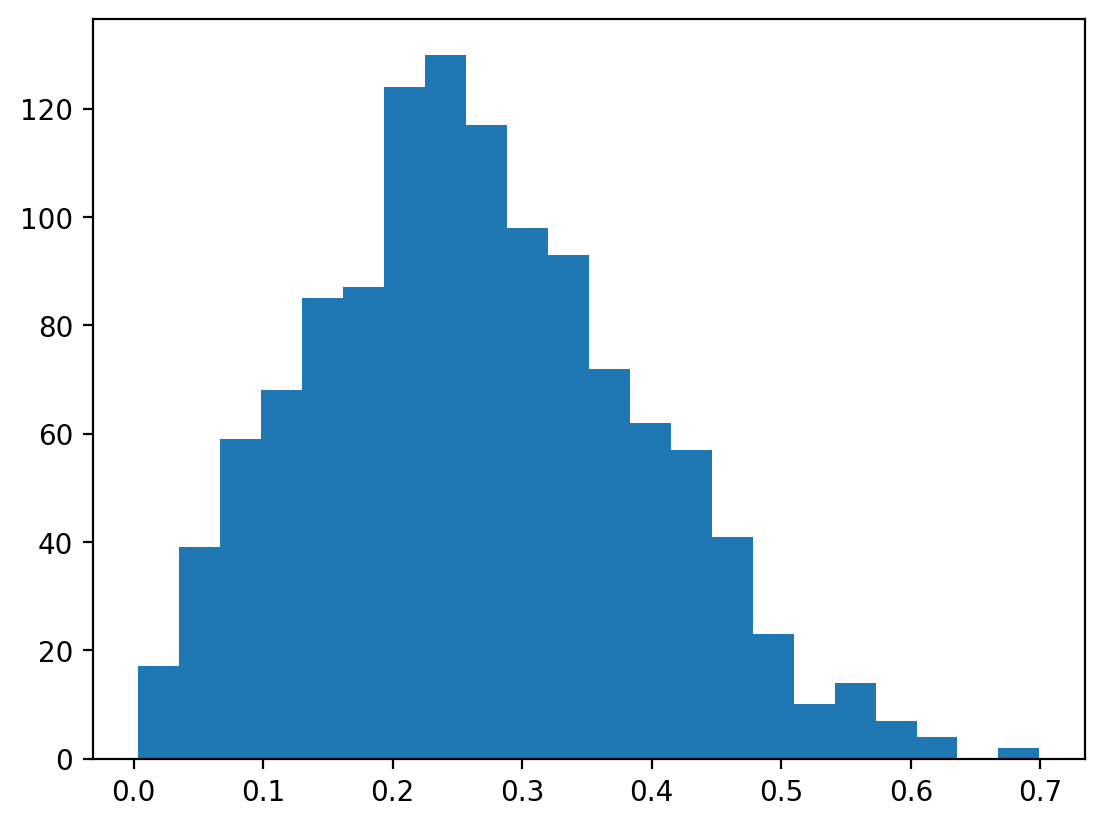

In [19]:
plt.hist(aniso_cell_values_d[9], bins="auto")
plt.show

Il y a une différence significative entre les moyennes des deux populations.


IndexError: list index out of range

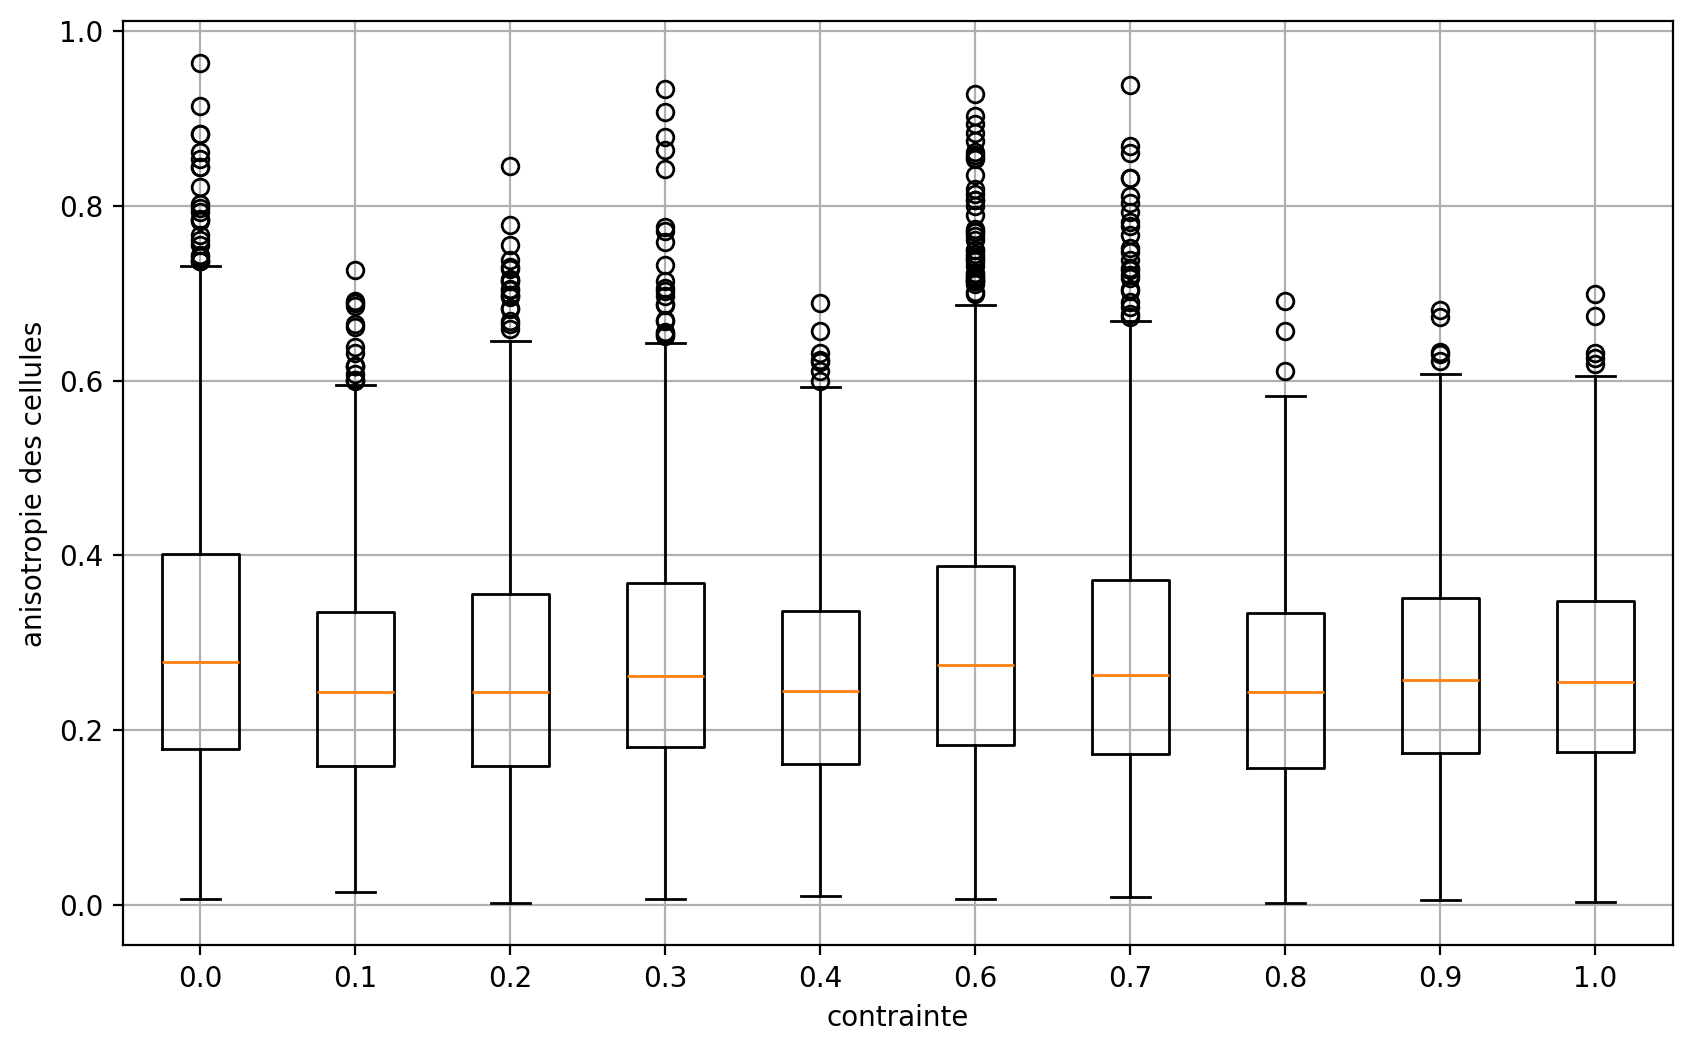

In [20]:
import matplotlib.pyplot as plt
from scipy.stats import levene, f_oneway, ttest_ind

plt.figure(figsize=(10, 6))
plt.boxplot(aniso_cell_values_d)
plt.xlabel('contrainte')
plt.ylabel('anisotropie des cellules')
plt.xticks(range(1, len(aniso_cell_values_d) + 1), ['{:.1f}'.format(i) for i in br])
plt.grid(True)

statistic, p_value = ttest_ind(aniso_cell_values_d[0], aniso_cell_values_d[9])

# Interpréter les résultats du test
if p_value > 0.05:
    print("Il n'y a pas de différence significative entre les moyennes des deux populations.")
else:
    print("Il y a une différence significative entre les moyennes des deux populations.")
    x_pos1 = 1
    x_pos2 = 10
    y_pos = max(max(aniso_cell_values_d[i]), max(aniso_cell_values_d[i+1])) + 0.3
    plt.plot([x_pos1, x_pos2], [y_pos, y_pos], color='black', linewidth=1.5)
    if p_value < 0.0001:
        plt.text((x_pos1 + x_pos2) / 2, y_pos, '****'.format(0.0001), ha='center')
    elif p_value < 0.001:
        plt.text((x_pos1 + x_pos2) / 2, y_pos, '***'.format(0.001), ha='center')
    elif p_value < 0.01:
        plt.text((x_pos1 + x_pos2) / 2, y_pos, '**'.format(0.01), ha='center')
    elif p_value < 0.05:
        plt.text((x_pos1 + x_pos2) / 2, y_pos, '*'.format(0.05), ha='center')
    
stat_levene, p_value_levene = levene(*aniso_cell_values_d)

# Interpréter les résultats de Levene
# Appliquer le test de Levene pour vérifier l'homogénéité des variances
if p_value_levene > 0.05:
    print("Les variances entre les populations sont homogènes.")
    # Appliquer le test d'ANOVA
    statistique, p_value_anova = f_oneway(aniso_cell_values_d[0], aniso_cell_values_d[-1])
    # Interpréter les résultats de l'ANOVA
    if p_value_anova > 0.05:
        print("Il n'y a pas de différence significative entre les moyennes des populations.")
    else:
        print("Il y a une différence significative entre les moyennes des populations.")
        for i in range(len(aniso_cell_values_d) - 1):
            x_pos1 = i+1
            x_pos2 = i+2
            y_pos = max(max(aniso_cell_values_d[i]), max(aniso_cell_values_d[i + 1])) + 0.05
            _, p_value_anova = f_oneway(aniso_cell_values_d[i], aniso_cell_values_d[9])

            # Placez le texte des étoiles en fonction de la position des barres
            if p_value_anova < 0.0001:
                plt.plot([x_pos1, x_pos2], [y_pos, y_pos], color='black', linewidth=1.5)
                plt.text((x_pos1 + x_pos2) / 2, y_pos, '****'.format(0.0001), ha='center')
            elif p_value_anova < 0.001:
                plt.plot([x_pos1, x_pos2], [y_pos, y_pos], color='black', linewidth=1.5)
                plt.text((x_pos1 + x_pos2) / 2, y_pos, '***'.format(0.001), ha='center')
            elif p_value_anova < 0.01:
                plt.plot([x_pos1, x_pos2], [y_pos, y_pos], color='black', linewidth=1.5)
                plt.text((x_pos1 + x_pos2) / 2, y_pos, '**'.format(0.01), ha='center')
            elif p_value_anova < 0.05:
                plt.plot([x_pos1, x_pos2], [y_pos, y_pos], color='black', linewidth=1.5)
                plt.text((x_pos1 + x_pos2) / 2, y_pos, '*'.format(0.05), ha='center')

else:
    print("Les variances entre les populations ne sont pas homogènes.")
plt.savefig('../image/aniso_barrier_elasticity_pol.png', transparent=True)
plt.show()


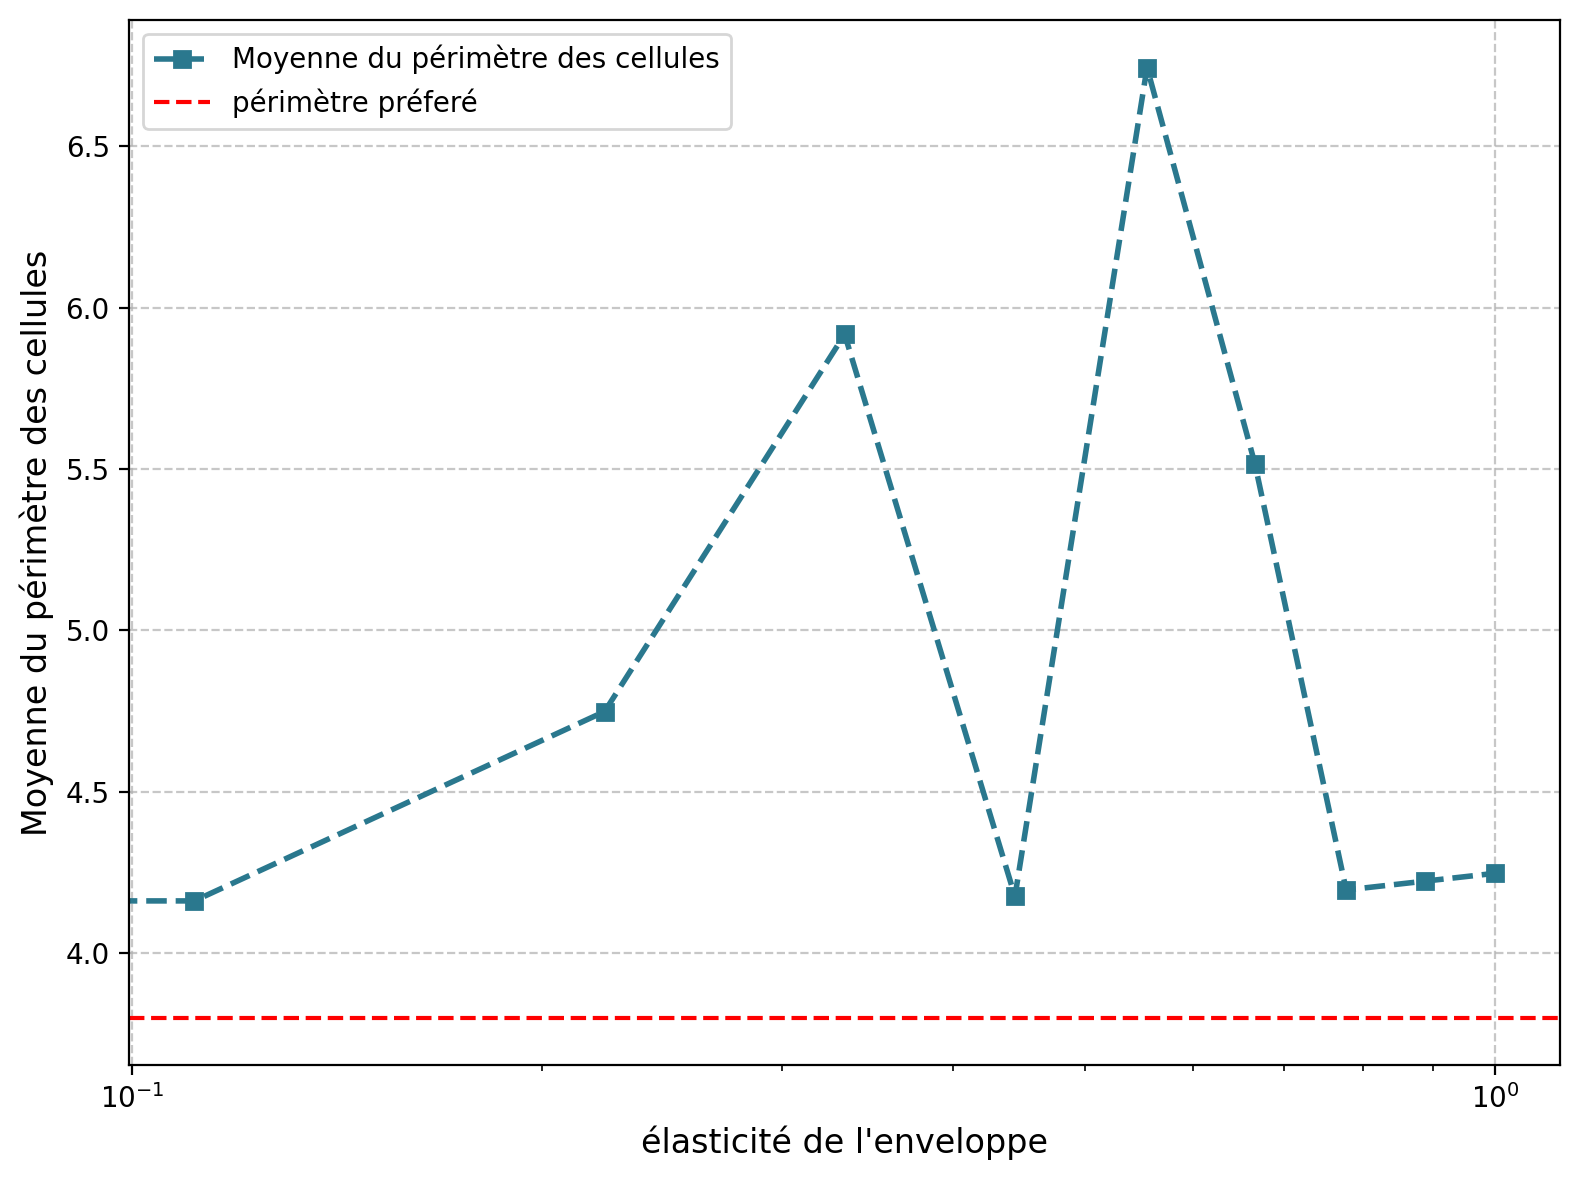

In [21]:
colors = plt.cm.viridis_r([0.2, 0.6])
fig, axs = plt.subplots(1, figsize=(8, 6))
axs.plot(br, cell_perimeters, label='Moyenne du périmètre des cellules', color=colors[1], marker='s', linestyle='--', linewidth=2)
plt.axhline(y=3.80, color='r', linestyle='--', label='périmètre préferé')
axs.set_xscale('log')
axs.set_xlabel("élasticité de l'enveloppe", fontsize=12)
axs.set_ylabel('Moyenne du périmètre des cellules', fontsize=12)


axs.grid(True, linestyle='--', alpha=0.7)
axs.legend(loc='best', fontsize=10)
plt.tight_layout()
plt.savefig('../image/cell_perimeters_elasticity_barrier_pol.png', transparent=True)
plt.show()

In [ ]:
colors = plt.cm.viridis_r([0.2, 0.6])
fig, axs = plt.subplots(1, figsize=(8, 6))
axs.plot(br, areas, label='Moyenne des aires des cellules', color=colors[1], marker='s', linestyle='--', linewidth=2)
plt.axhline(y=1, color='r', linestyle='--', label='aire préférée')
axs.set_xlabel("élasticité de l'enveloppe", fontsize=12)
axs.set_ylabel('Moyenne des aires des cellules', fontsize=12)


axs.grid(True, linestyle='--', alpha=0.7)
axs.legend(loc='best', fontsize=10)
plt.tight_layout()
plt.savefig('../image/cell_area_elasticity_barrier_pol.png', transparent=False)
plt.show()